# October 26th, 2021

**Motivation**: plotting Ca and Bold results side by side + entropy results <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
from scipy.ndimage import gaussian_filter

def show_h(proj_h, proj_hr, cmap='icefire', interp='antialiased'):
    fig, axes = create_figure(1, 4, (13., 3), gridspec_kw={'width_ratios': [1.8, 1, 1, 1.8]})

    x2plt = proj_h['parcel2d-flat'].squeeze()
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    im = axes[0].imshow(x2plt, cmap=cmap, interpolation=interp)
    plt.colorbar(im, ax=axes[0], shrink=0.4)

    x2plt = proj_h['parcel2d-top'].squeeze()
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    axes[1].imshow(x2plt, cmap=cmap, interpolation=interp)

    x2plt = proj_hr['parcel2d-top'].squeeze()
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    axes[2].imshow(x2plt, cmap=cmap, interpolation=interp)

    x2plt = proj_hr['parcel2d-flat'].squeeze()
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    im = axes[3].imshow(x2plt, cmap=cmap, interpolation=interp)
    plt.colorbar(im, ax=axes[3], shrink=0.4)

    remove_ticks(axes)
    plt.show()
    
    
def get_h(pi_arr, approach='pi_animals'):
    if approach == 'pi_animals':
        pi = bn.nanmean(pi_arr, -3)
        pi = bn.nanmean(bn.nanmean(pi, 2), 1)
        h = sp_stats.entropy(pi, axis=-2) / np.log(pi.shape[-2])
        h = bn.nanmean(h, 0)
        hr = sp_stats.rankdata(h)
    elif approach == 'avg_pi_first':
        pi = bn.nanmean(pi_arr, -3)
        pi = bn.nanmean(bn.nanmean(bn.nanmean(pi, 2), 1), 0)
        h = sp_stats.entropy(pi, axis=0) / np.log(len(pi))
        hr = sp_stats.rankdata(h)
    elif approach == 'no_pi_avg':
        h_arr = sp_stats.entropy(pi_arr, axis=-2) / np.log(pi_arr.shape[-2])
        h = bn.nanmean(h_arr, -3)
        h = bn.nanmean(bn.nanmean(bn.nanmean(h, 2), 1), 0)
    hr = sp_stats.rankdata(h)
    proj_h = gr.project_vec(h)
    proj_hr = gr.project_vec(hr)
    return h, hr, proj_h, proj_hr

In [3]:
%%time

mice = Mice((192, 4))

CPU times: user 213 ms, sys: 1.54 s, total: 1.75 s
Wall time: 13.8 s


In [4]:
mice.setup_func_data()

## k5 / p15-sample

In [5]:
props = {
    'mice': mice,
    'num_k': 5,
    'perc': 'p15-sample',
    'metric': 'pearson',
    'match_metric': 'euclidean',
    'match_using': 'gam',
    'prepare_data': False,
    'verbose': False,
}

### Bold & Ca2

In [6]:
gr = Group(mode='ca2', centroids_from='runs', **props)
pi_arr_ca, _, _ = gr.fit_group(skip_align=False)

pi = bn.nanmean(pi_arr_ca, -3)
pi_ca = bn.nanmean(pi.reshape(-1, *pi.shape[-2:]), 0)
disjoint = gr.get_disjoint_community(pi_ca, to_vec=True)
pi_ca = np.concatenate([pi_ca, np.expand_dims(disjoint, 0)])

Warning, nan in global order

In [7]:
gr = Group(mode='bold-lite', centroids_from='runs', **props)
pi_arr_bold, _, _ = gr.fit_group(skip_align=False)

pi = bn.nanmean(pi_arr_bold, -3)
pi_bold = bn.nanmean(pi.reshape(-1, *pi.shape[-2:]), 0)
disjoint = gr.get_disjoint_community(pi_bold, to_vec=True)
pi_bold = np.concatenate([pi_bold, np.expand_dims(disjoint, 0)])

Warning, nan in global order

In [8]:
proj_ca = gr.project_vec(pi_ca)
proj_bold = gr.project_vec(pi_bold)

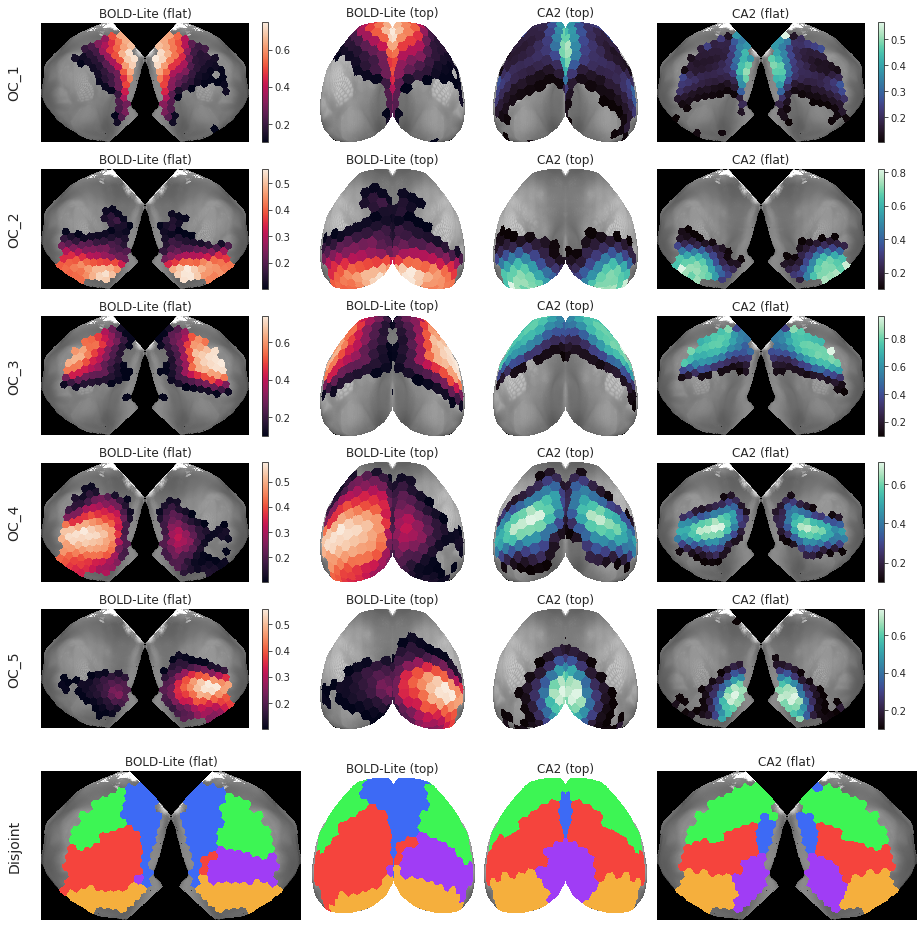

In [10]:
gr.show(proj_bold, proj_ca, labels=('BOLD-Lite', 'CA2'), cmaps=('rocket', 'mako'))

In [11]:
sv = SVINET(**props, mode='ca2')
sv.pi_symmetry_score(pi_ca, 3)

{1: 0.984, 2: 0.986, 3: 0.992, 4: 0.991, 5: 0.985, -1: 0.987}

In [12]:
sv = SVINET(**props, mode='bold-lite')
sv.pi_symmetry_score(pi_bold, 3)

{1: 0.994, 2: 0.995, 3: 0.982, 4: 0.888, 5: 0.891, -1: 0.95}

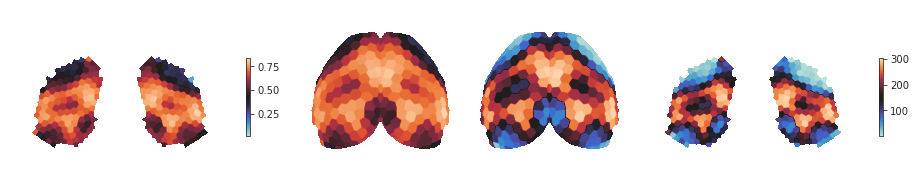

In [15]:
h_ca, hr, proj_h, proj_hr = get_h(pi_arr_ca, 'pi_animals')
show_h(proj_h, proj_hr)

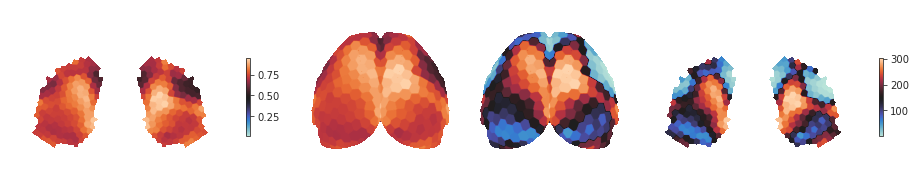

In [16]:
h_bold, hr, proj_h, proj_hr = get_h(pi_arr_bold, 'pi_animals')
show_h(proj_h, proj_hr)

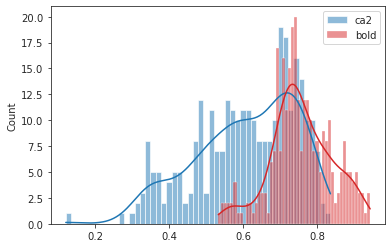

In [22]:
sns.histplot(h_ca, bins=50, color='C0', kde=True, label='ca2')
sns.histplot(h_bold, bins=50, color='C3', kde=True, label='bold')
plt.legend()
plt.show()

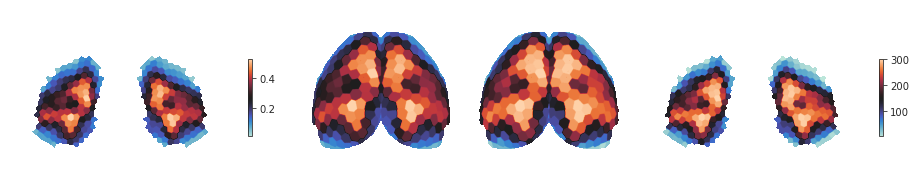

In [23]:
h_ca, hr, proj_h, proj_hr = get_h(pi_arr_ca, 'no_pi_avg')
show_h(proj_h, proj_hr)

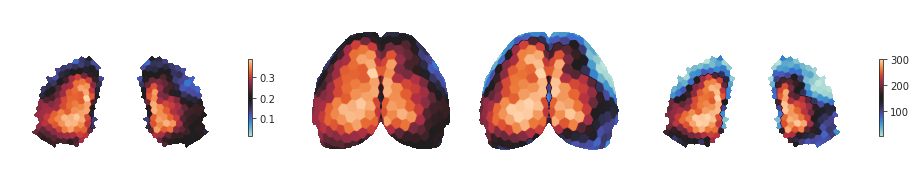

In [24]:
h_bold, hr, proj_h, proj_hr = get_h(pi_arr_bold, 'no_pi_avg')
show_h(proj_h, proj_hr)

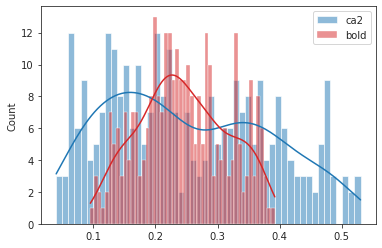

In [25]:
sns.histplot(h_ca, bins=50, color='C0', kde=True, label='ca2')
sns.histplot(h_bold, bins=50, color='C3', kde=True, label='bold')
plt.legend()
plt.show()

### Ca2

#### Don't skip align

In [5]:
gr = Group(mode='ca2', centroids_from='runs', **props)
pi_arr, gam_arr, lam_arr = gr.fit_group(skip_align=False)

Warning, nan in global order

In [6]:
pi = bn.nanmean(pi_arr, -3)
pi_ca = bn.nanmean(pi.reshape(-1, *pi.shape[-2:]), 0)

disjoint = gr.get_disjoint_community(pi_ca, to_vec=True)
pi_ca = np.concatenate([pi_ca, np.expand_dims(disjoint, 0)])

pi_ca.shape

(6, 302)

In [7]:
proj_ca = gr.project_vec(pi_ca)

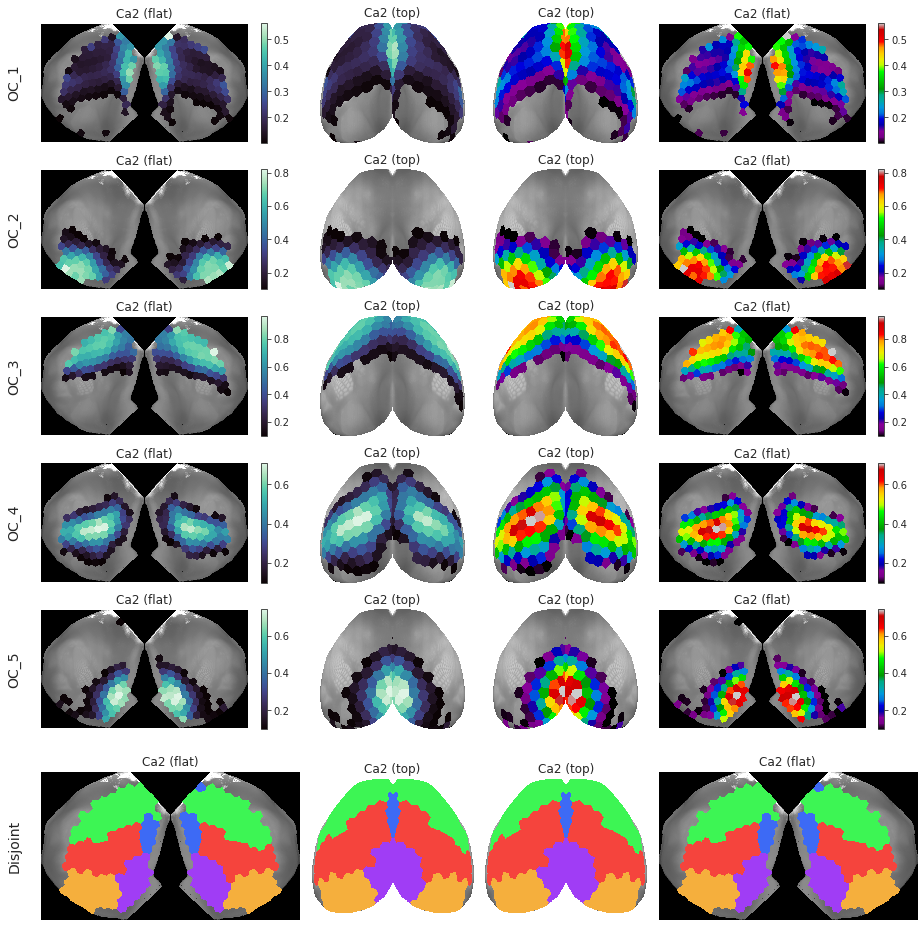

In [8]:
gr.show(proj_ca, labels=('Ca2',) * 2, cmaps=('mako', 'nipy_spectral'))

In [9]:
sv = SVINET(**props, mode='ca2')
sv.pi_symmetry_score(pi_ca, 3)

{1: 0.984, 2: 0.986, 3: 0.992, 4: 0.991, 5: 0.985, -1: 0.987}

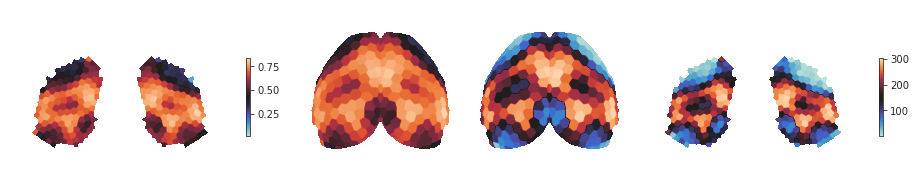

In [11]:
h, hr, proj_h, proj_hr = get_h(pi_arr, 'pi_animals')
show_h(proj_h, proj_hr)

<AxesSubplot:ylabel='Count'>

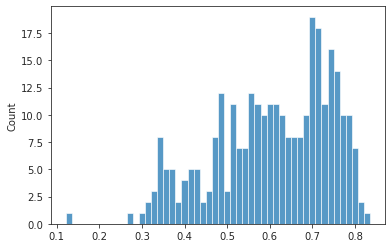

In [12]:
sns.histplot(h, bins=50)

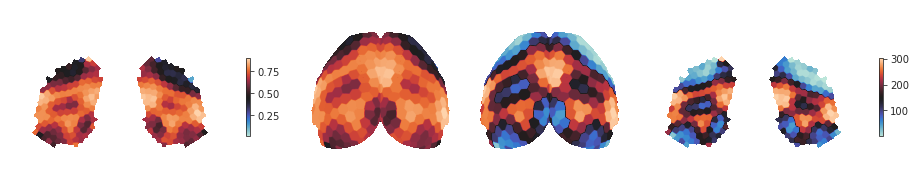

In [13]:
h, hr, proj_h, proj_hr = get_h(pi_arr, 'avg_pi_first')
show_h(proj_h, proj_hr)

<AxesSubplot:ylabel='Count'>

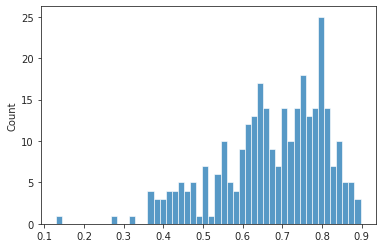

In [14]:
sns.histplot(h, bins=50)

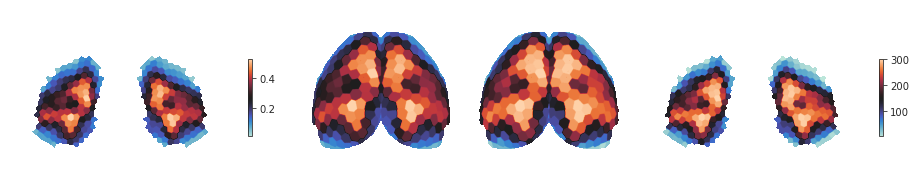

In [15]:
h, hr, proj_h, proj_hr = get_h(pi_arr, 'no_pi_avg')
show_h(proj_h, proj_hr)

<AxesSubplot:ylabel='Count'>

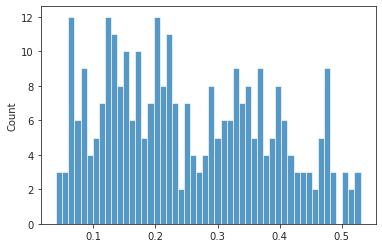

In [16]:
sns.histplot(h, bins=50)

#### Skip align

In [17]:
gr = Group(mode='ca2', centroids_from='runs', **props)
pi_arr, gam_arr, lam_arr = gr.fit_group(skip_align=True)

In [18]:
pi = bn.nanmean(pi_arr, -3)
pi_ca = bn.nanmean(pi.reshape(-1, *pi.shape[-2:]), 0)

disjoint = gr.get_disjoint_community(pi_ca, to_vec=True)
pi_ca = np.concatenate([pi_ca, np.expand_dims(disjoint, 0)])

pi_ca.shape

(6, 302)

In [19]:
proj_ca = gr.project_vec(pi_ca)

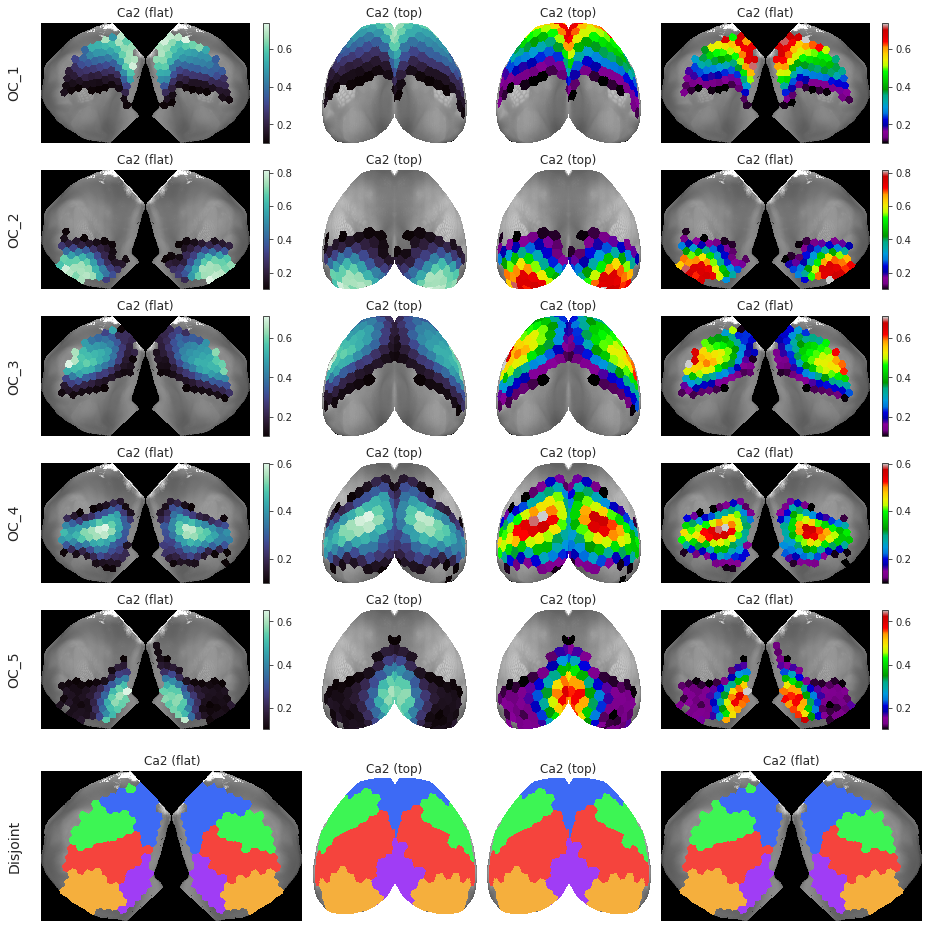

In [20]:
gr.show(proj_ca, labels=('Ca2',) * 2, cmaps=('mako', 'nipy_spectral'))

In [21]:
sv = SVINET(**props, mode='ca2')
sv.pi_symmetry_score(pi_ca, 3)

{1: 0.988, 2: 0.984, 3: 0.99, 4: 0.984, 5: 0.978, -1: 0.985}

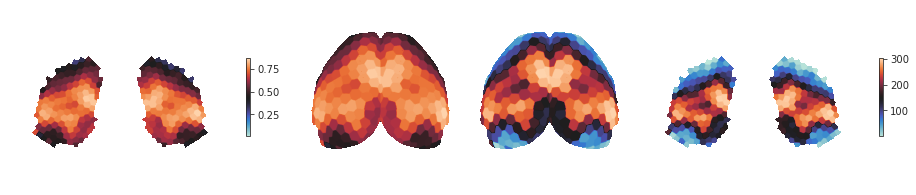

In [22]:
h, hr, proj_h, proj_hr = get_h(pi_arr, 'pi_animals')
show_h(proj_h, proj_hr)

<AxesSubplot:ylabel='Count'>

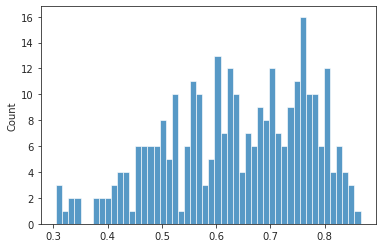

In [23]:
sns.histplot(h, bins=50)

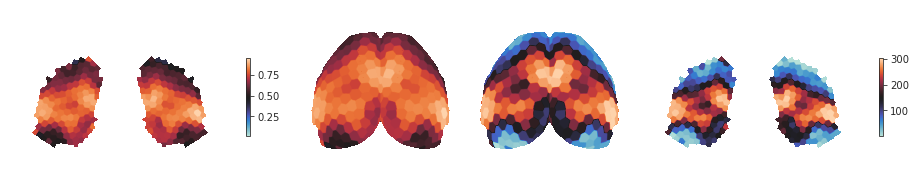

In [24]:
h, hr, proj_h, proj_hr = get_h(pi_arr, 'avg_pi_first')
show_h(proj_h, proj_hr)

<AxesSubplot:ylabel='Count'>

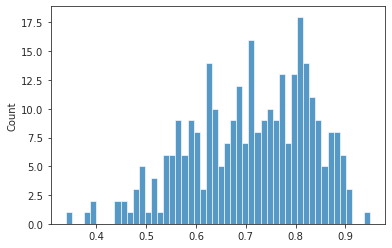

In [25]:
sns.histplot(h, bins=50)

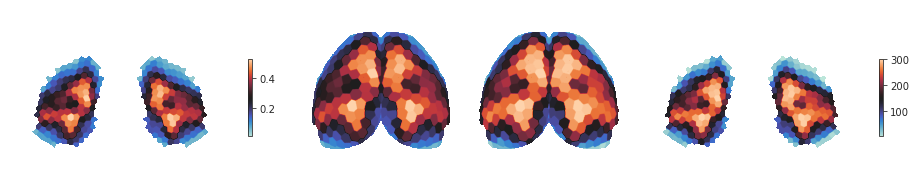

In [26]:
h, hr, proj_h, proj_hr = get_h(pi_arr, 'no_pi_avg')
show_h(proj_h, proj_hr)

<AxesSubplot:ylabel='Count'>

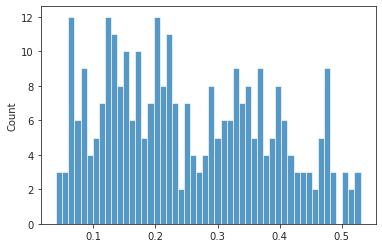

In [27]:
sns.histplot(h, bins=50)

### BOLD-Lite

#### Don't skip align

In [30]:
gr = Group(mode='bold-lite', centroids_from='runs', **props)
pi_arr, gam_arr, lam_arr = gr.fit_group(skip_align=False)

Warning, nan in global order

In [31]:
pi = bn.nanmean(pi_arr, -3)
pi_bold = bn.nanmean(pi.reshape(-1, *pi.shape[-2:]), 0)

disjoint = gr.get_disjoint_community(pi_bold, to_vec=True)
pi_bold = np.concatenate([pi_bold, np.expand_dims(disjoint, 0)])

pi_bold.shape

(6, 302)

In [33]:
proj_bold = gr.project_vec(pi_bold)

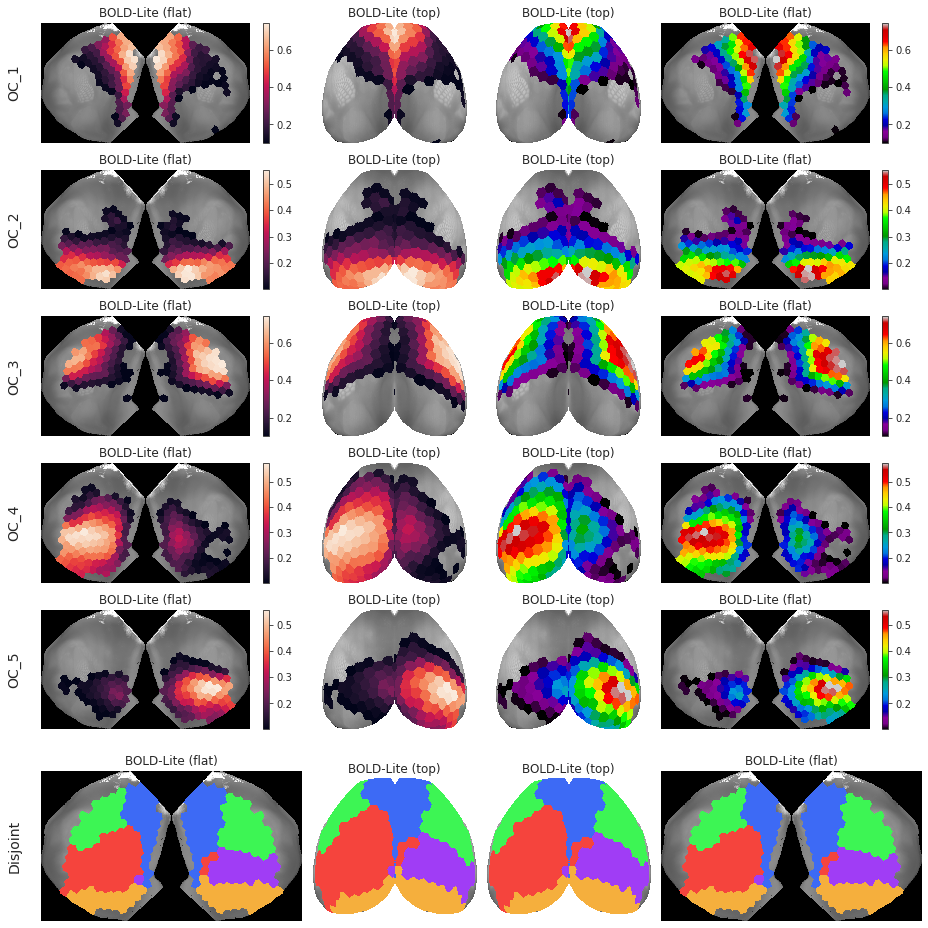

In [34]:
gr.show(proj_bold, labels=('BOLD-Lite',) * 2, cmaps=('rocket', 'nipy_spectral'))

In [35]:
sv = SVINET(**props, mode='bold-lite')
sv.pi_symmetry_score(pi_ca, 3)

{1: 0.988, 2: 0.984, 3: 0.99, 4: 0.984, 5: 0.978, -1: 0.985}

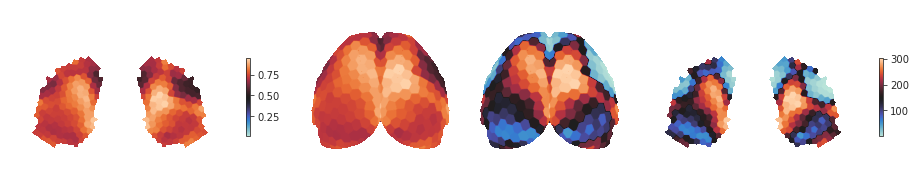

In [36]:
h, hr, proj_h, proj_hr = get_h(pi_arr, 'pi_animals')
show_h(proj_h, proj_hr)

<AxesSubplot:ylabel='Count'>

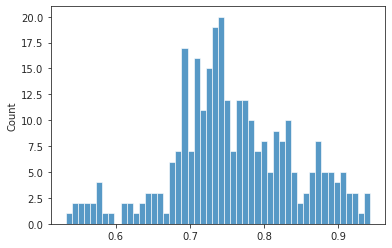

In [37]:
sns.histplot(h, bins=50)

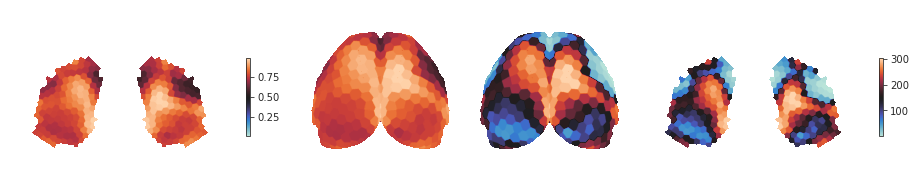

In [38]:
h, hr, proj_h, proj_hr = get_h(pi_arr, 'avg_pi_first')
show_h(proj_h, proj_hr)

<AxesSubplot:ylabel='Count'>

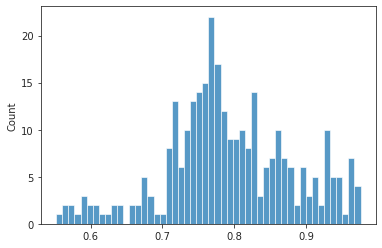

In [39]:
sns.histplot(h, bins=50)

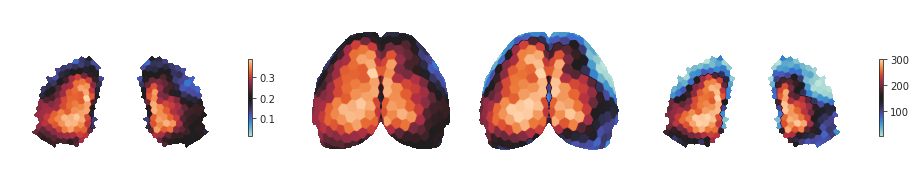

In [40]:
h, hr, proj_h, proj_hr = get_h(pi_arr, 'no_pi_avg')
show_h(proj_h, proj_hr)

<AxesSubplot:ylabel='Count'>

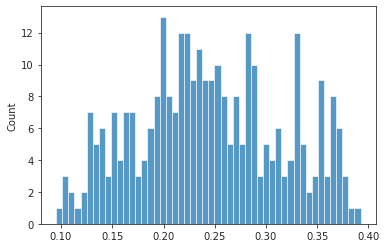

In [41]:
sns.histplot(h, bins=50)

#### Skip align

In [42]:
gr = Group(mode='bold-lite', centroids_from='runs', **props)
pi_arr, gam_arr, lam_arr = gr.fit_group(skip_align=True)

In [43]:
pi = bn.nanmean(pi_arr, -3)
pi_bold = bn.nanmean(pi.reshape(-1, *pi.shape[-2:]), 0)

disjoint = gr.get_disjoint_community(pi_bold, to_vec=True)
pi_bold = np.concatenate([pi_bold, np.expand_dims(disjoint, 0)])

pi_bold.shape

(6, 302)

In [44]:
proj_bold = gr.project_vec(pi_bold)

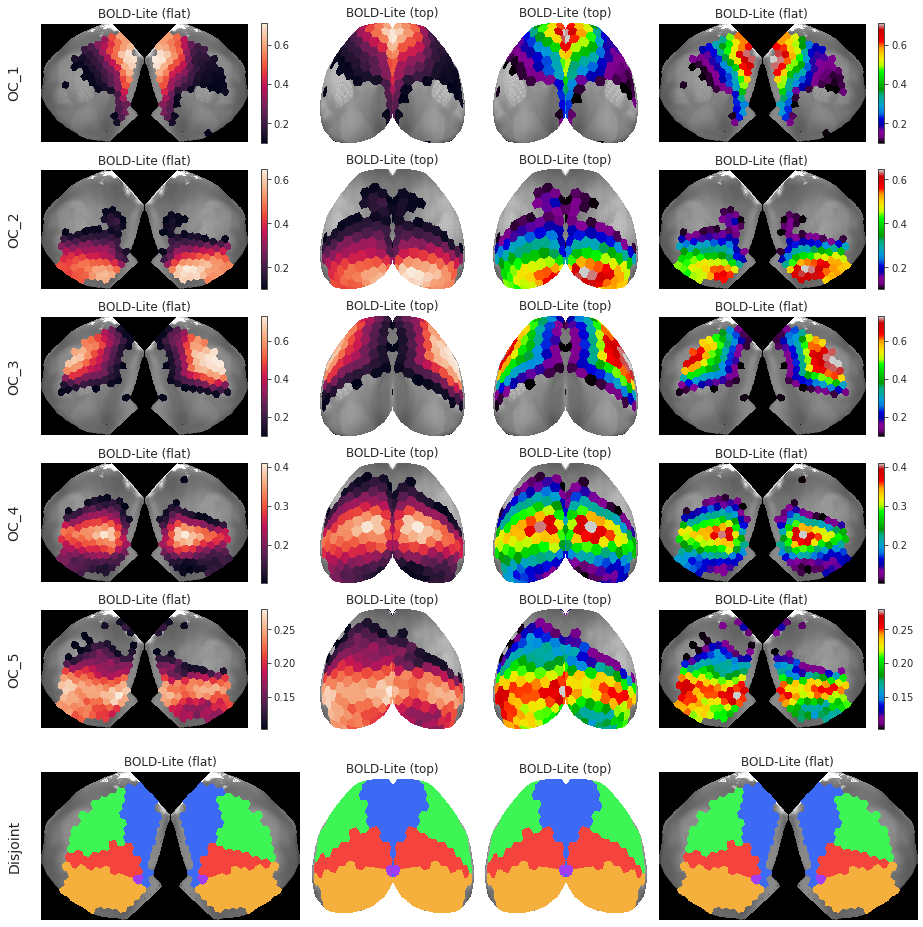

In [45]:
gr.show(proj_bold, labels=('BOLD-Lite',) * 2, cmaps=('rocket', 'nipy_spectral'))

In [48]:
sv = SVINET(**props, mode='bold-lite')
sv.pi_symmetry_score(pi_ca, 3)

{1: 0.988, 2: 0.984, 3: 0.99, 4: 0.984, 5: 0.978, -1: 0.985}

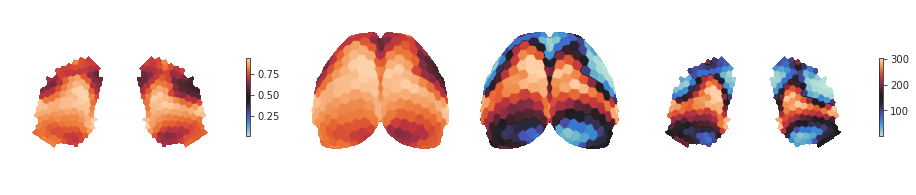

In [49]:
h, hr, proj_h, proj_hr = get_h(pi_arr, 'pi_animals')
show_h(proj_h, proj_hr)

<AxesSubplot:ylabel='Count'>

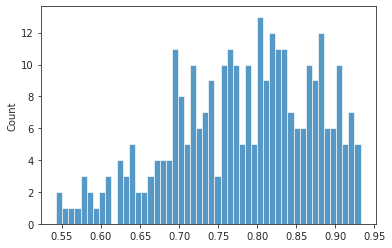

In [50]:
sns.histplot(h, bins=50)

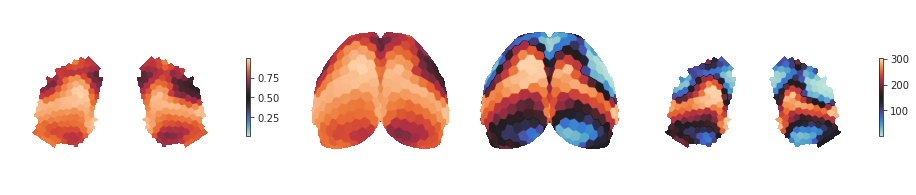

In [51]:
h, hr, proj_h, proj_hr = get_h(pi_arr, 'avg_pi_first')
show_h(proj_h, proj_hr)

<AxesSubplot:ylabel='Count'>

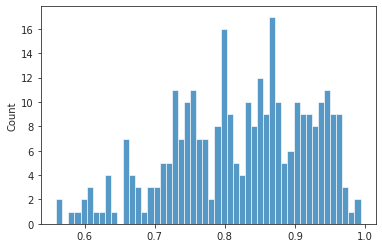

In [52]:
sns.histplot(h, bins=50)

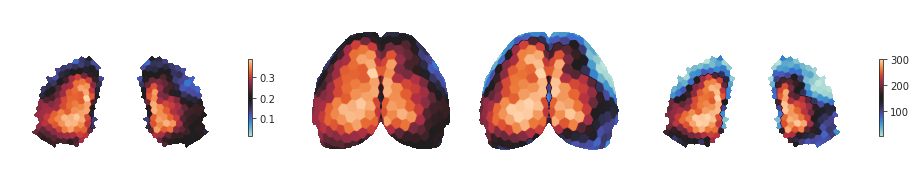

In [53]:
h, hr, proj_h, proj_hr = get_h(pi_arr, 'no_pi_avg')
show_h(proj_h, proj_hr)

<AxesSubplot:ylabel='Count'>

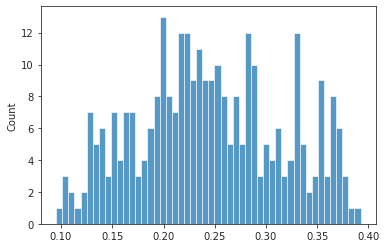

In [54]:
sns.histplot(h, bins=50)

## k6 / p10-sample

In [5]:
props = {
    'mice': mice,
    'num_k': 6,
    'perc': 'p10-sample',
    'metric': 'pearson',
    'match_metric': 'euclidean',
    'match_using': 'gam',
    'prepare_data': False,
    'verbose': False,
}

### Bold & Ca2

In [6]:
gr = Group(mode='ca2', centroids_from='runs', **props)
pi_arr_ca, _, _ = gr.fit_group(skip_align=False)

pi = bn.nanmean(pi_arr_ca, -3)
pi_ca = bn.nanmean(pi.reshape(-1, *pi.shape[-2:]), 0)
disjoint = gr.get_disjoint_community(pi_ca, to_vec=True)
pi_ca = np.concatenate([pi_ca, np.expand_dims(disjoint, 0)])

Warning, nan in global order

In [7]:
gr = Group(mode='bold-lite', centroids_from='runs', **props)
pi_arr_bold, _, _ = gr.fit_group(skip_align=False)

pi = bn.nanmean(pi_arr_bold, -3)
pi_bold = bn.nanmean(pi.reshape(-1, *pi.shape[-2:]), 0)
disjoint = gr.get_disjoint_community(pi_bold, to_vec=True)
pi_bold = np.concatenate([pi_bold, np.expand_dims(disjoint, 0)])

Warning, nan in global order

In [8]:
proj_ca = gr.project_vec(pi_ca)
proj_bold = gr.project_vec(pi_bold)

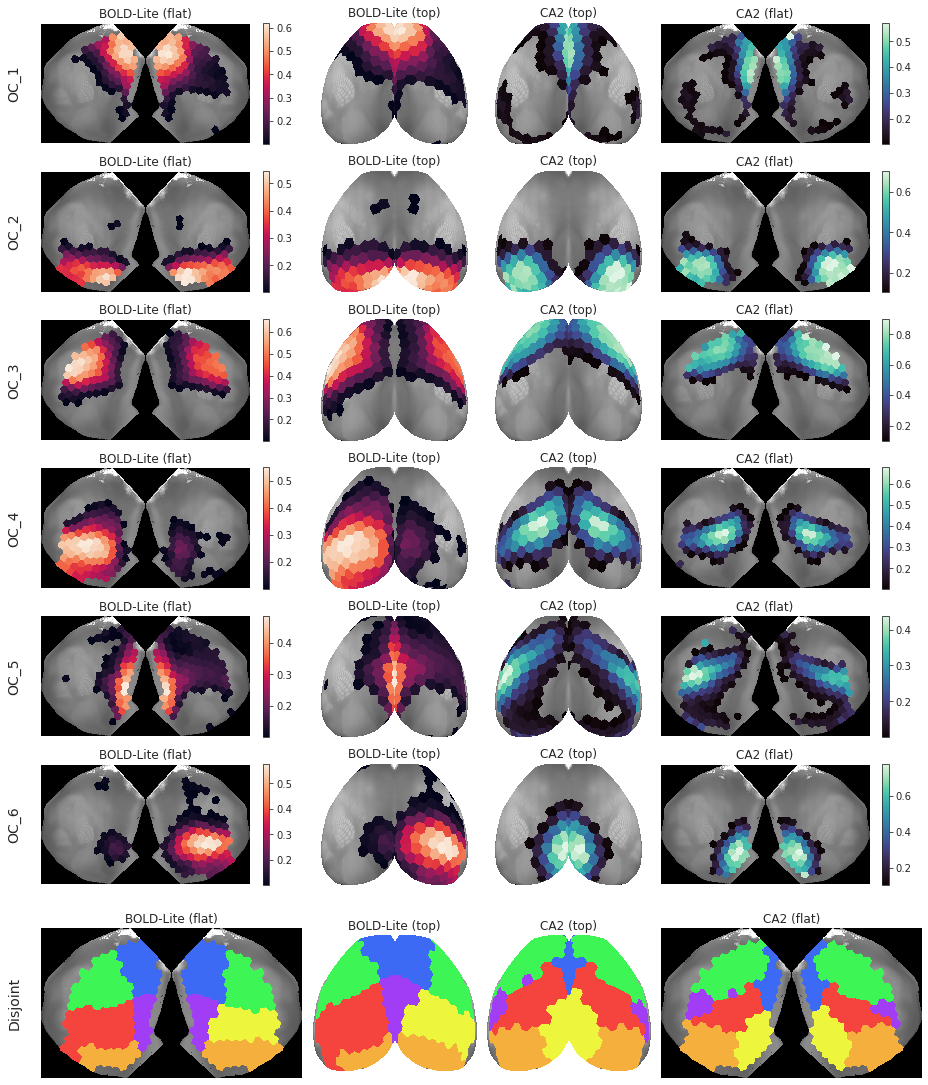

In [9]:
gr.show(proj_bold, proj_ca, labels=('BOLD-Lite', 'CA2'), cmaps=('rocket', 'mako'))

In [10]:
sv = SVINET(**props, mode='ca2')
sv.pi_symmetry_score(pi_ca, 3)

{1: 0.972, 2: 0.984, 3: 0.986, 4: 0.989, 5: 0.958, 6: 0.987, -1: 0.979}

In [11]:
sv = SVINET(**props, mode='bold-lite')
sv.pi_symmetry_score(pi_bold, 3)

{1: 0.988, 2: 0.997, 3: 0.994, 4: 0.89, 5: 0.981, 6: 0.855, -1: 0.951}

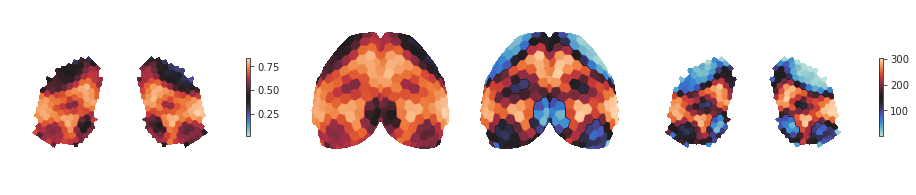

In [12]:
h_ca, hr, proj_h, proj_hr = get_h(pi_arr_ca, 'pi_animals')
show_h(proj_h, proj_hr)

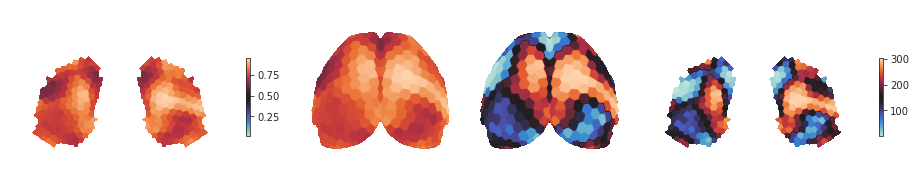

In [13]:
h_bold, hr, proj_h, proj_hr = get_h(pi_arr_bold, 'pi_animals')
show_h(proj_h, proj_hr)

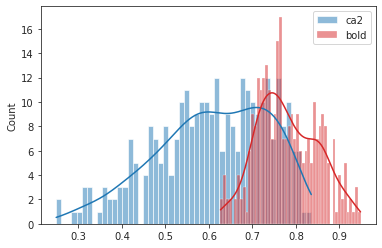

In [14]:
sns.histplot(h_ca, bins=50, color='C0', kde=True, label='ca2')
sns.histplot(h_bold, bins=50, color='C3', kde=True, label='bold')
plt.legend()
plt.show()

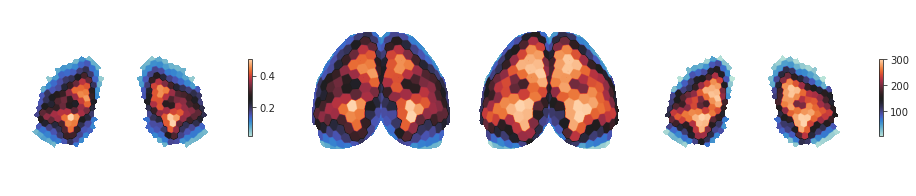

In [15]:
h_ca, hr, proj_h, proj_hr = get_h(pi_arr_ca, 'no_pi_avg')
show_h(proj_h, proj_hr)

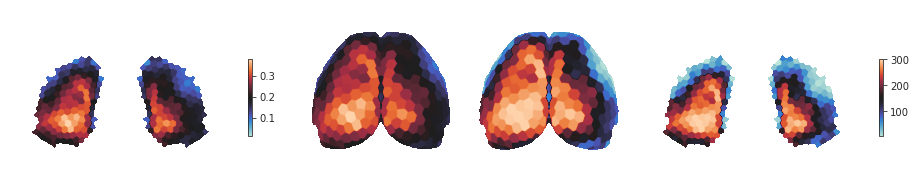

In [16]:
h_bold, hr, proj_h, proj_hr = get_h(pi_arr_bold, 'no_pi_avg')
show_h(proj_h, proj_hr)

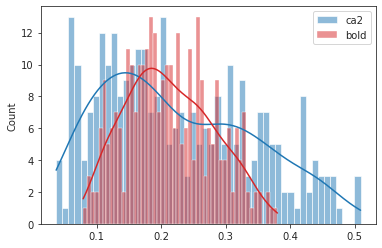

In [17]:
sns.histplot(h_ca, bins=50, color='C0', kde=True, label='ca2')
sns.histplot(h_bold, bins=50, color='C3', kde=True, label='bold')
plt.legend()
plt.show()

### Ca2

#### Don't skip align

In [18]:
gr = Group(mode='ca2', centroids_from='runs', **props)
pi_arr, gam_arr, lam_arr = gr.fit_group(skip_align=False)

Warning, nan in global order

In [19]:
pi = bn.nanmean(pi_arr, -3)
pi_ca = bn.nanmean(pi.reshape(-1, *pi.shape[-2:]), 0)

disjoint = gr.get_disjoint_community(pi_ca, to_vec=True)
pi_ca = np.concatenate([pi_ca, np.expand_dims(disjoint, 0)])

pi_ca.shape

(7, 302)

In [20]:
proj_ca = gr.project_vec(pi_ca)

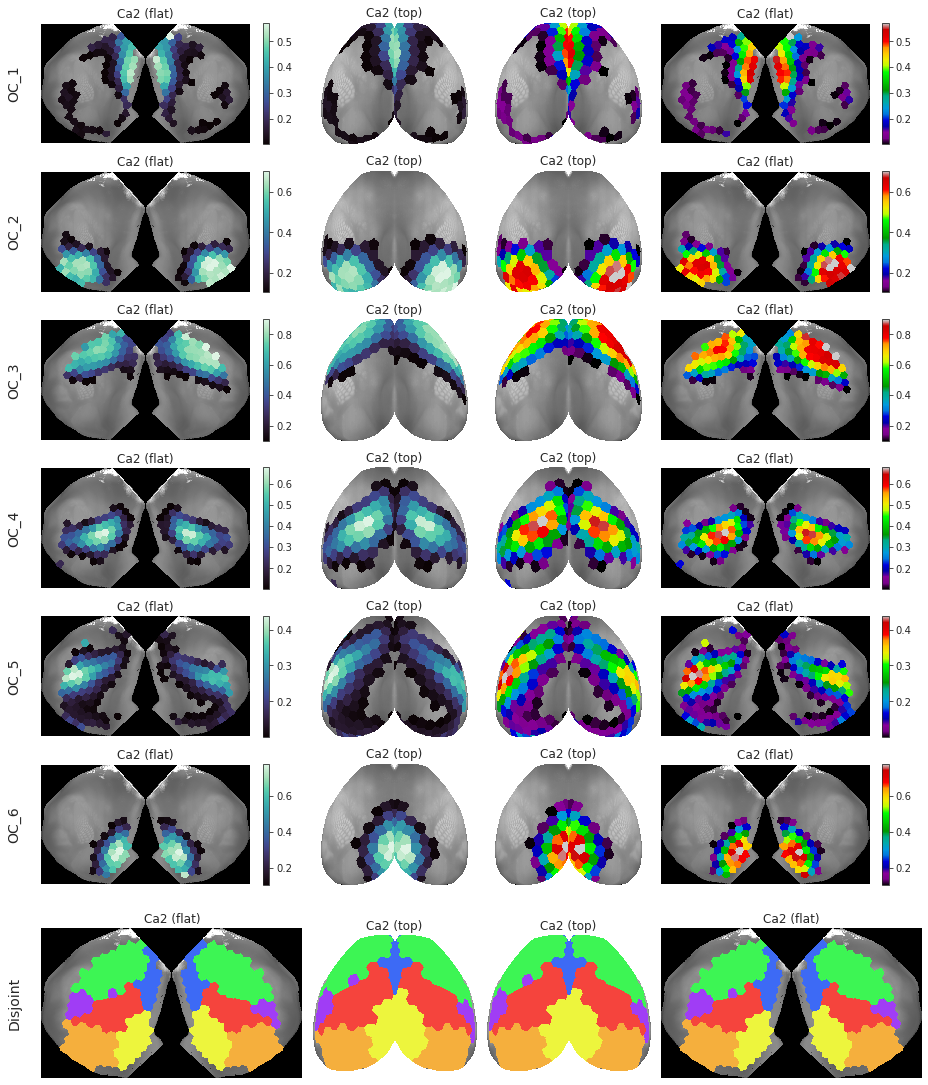

In [21]:
gr.show(proj_ca, labels=('Ca2',) * 2, cmaps=('mako', 'nipy_spectral'))

In [22]:
sv = SVINET(**props, mode='ca2')
sv.pi_symmetry_score(pi_ca, 3)

{1: 0.972, 2: 0.984, 3: 0.986, 4: 0.989, 5: 0.958, 6: 0.987, -1: 0.979}

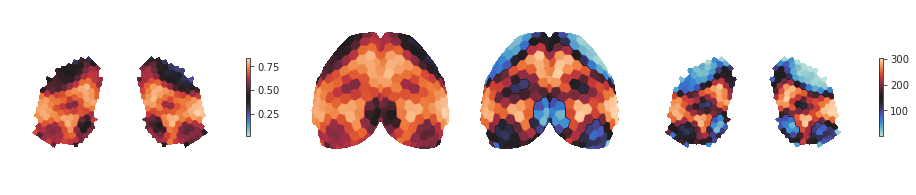

In [23]:
h, hr, proj_h, proj_hr = get_h(pi_arr, 'pi_animals')
show_h(proj_h, proj_hr)

<AxesSubplot:ylabel='Count'>

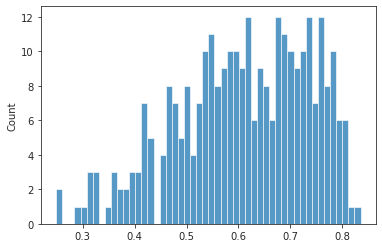

In [24]:
sns.histplot(h, bins=50)

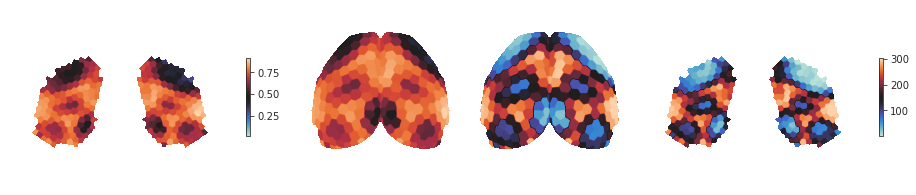

In [25]:
h, hr, proj_h, proj_hr = get_h(pi_arr, 'avg_pi_first')
show_h(proj_h, proj_hr)

<AxesSubplot:ylabel='Count'>

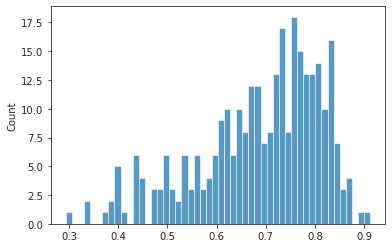

In [26]:
sns.histplot(h, bins=50)

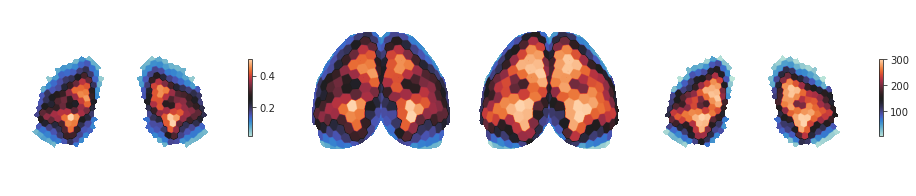

In [27]:
h, hr, proj_h, proj_hr = get_h(pi_arr, 'no_pi_avg')
show_h(proj_h, proj_hr)

<AxesSubplot:ylabel='Count'>

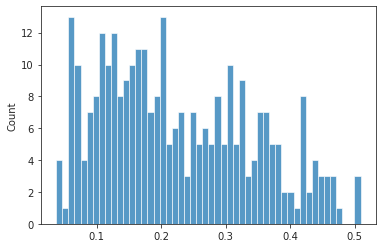

In [28]:
sns.histplot(h, bins=50)

#### Skip align

In [29]:
gr = Group(mode='ca2', centroids_from='runs', **props)
pi_arr, gam_arr, lam_arr = gr.fit_group(skip_align=True)

In [30]:
pi = bn.nanmean(pi_arr, -3)
pi_ca = bn.nanmean(pi.reshape(-1, *pi.shape[-2:]), 0)

disjoint = gr.get_disjoint_community(pi_ca, to_vec=True)
pi_ca = np.concatenate([pi_ca, np.expand_dims(disjoint, 0)])

pi_ca.shape

(7, 302)

In [31]:
proj_ca = gr.project_vec(pi_ca)

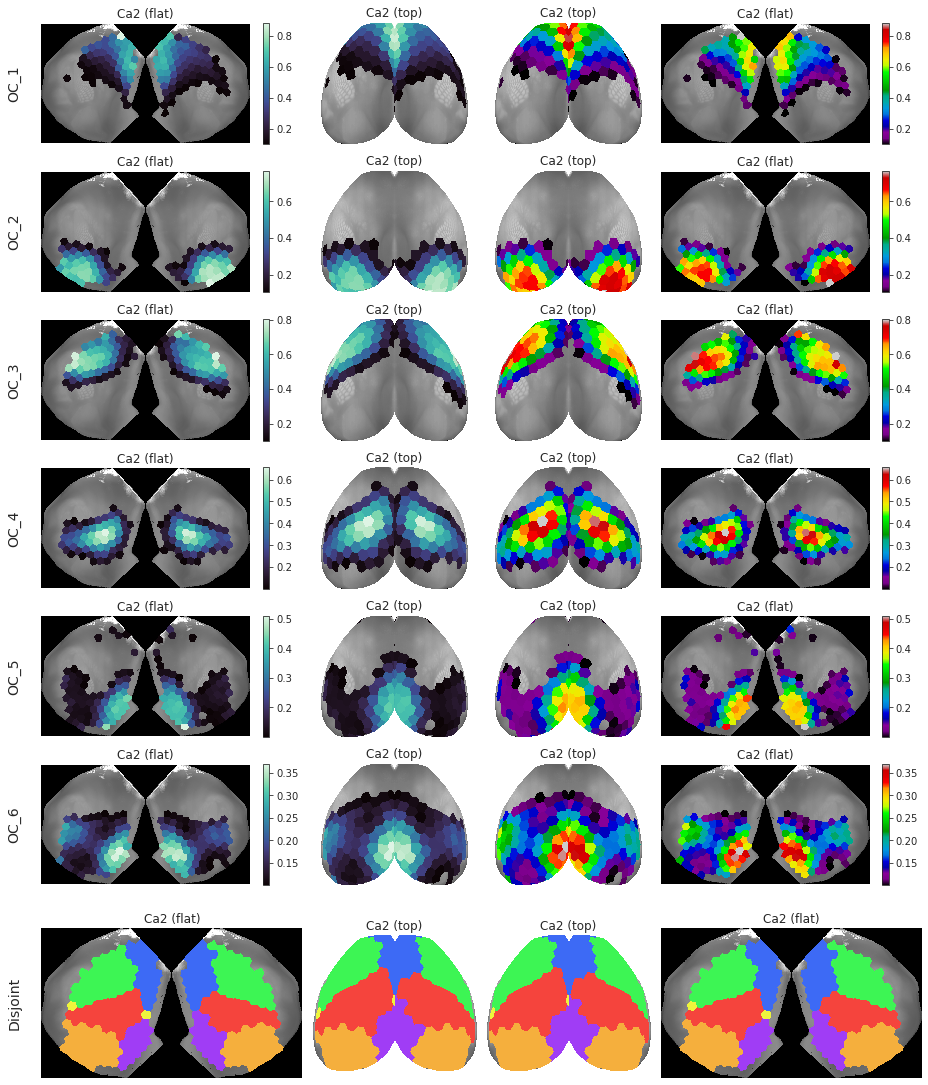

In [32]:
gr.show(proj_ca, labels=('Ca2',) * 2, cmaps=('mako', 'nipy_spectral'))

In [33]:
sv = SVINET(**props, mode='ca2')
sv.pi_symmetry_score(pi_ca, 3)

{1: 0.98, 2: 0.981, 3: 0.987, 4: 0.988, 5: 0.972, 6: 0.975, -1: 0.981}

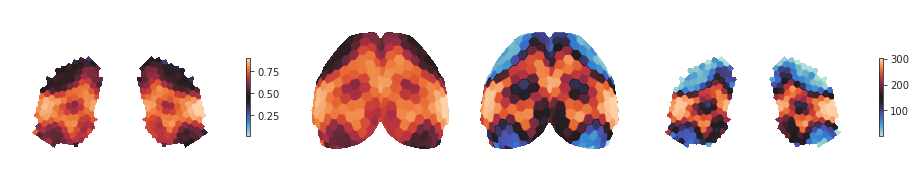

In [34]:
h, hr, proj_h, proj_hr = get_h(pi_arr, 'pi_animals')
show_h(proj_h, proj_hr)

<AxesSubplot:ylabel='Count'>

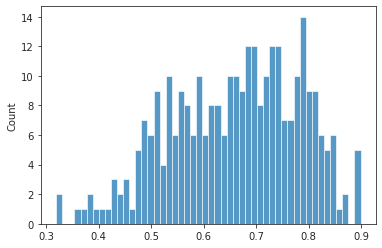

In [35]:
sns.histplot(h, bins=50)

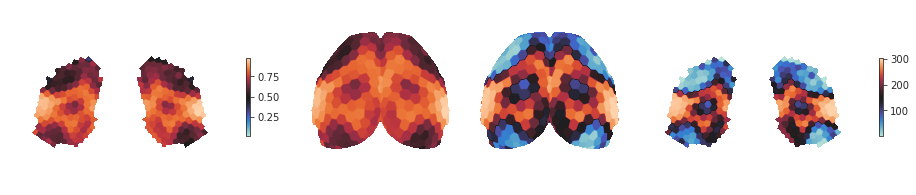

In [36]:
h, hr, proj_h, proj_hr = get_h(pi_arr, 'avg_pi_first')
show_h(proj_h, proj_hr)

<AxesSubplot:ylabel='Count'>

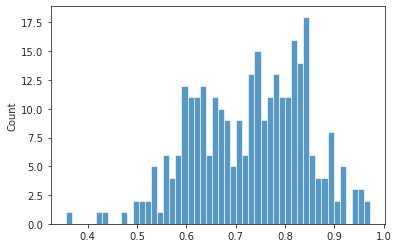

In [37]:
sns.histplot(h, bins=50)

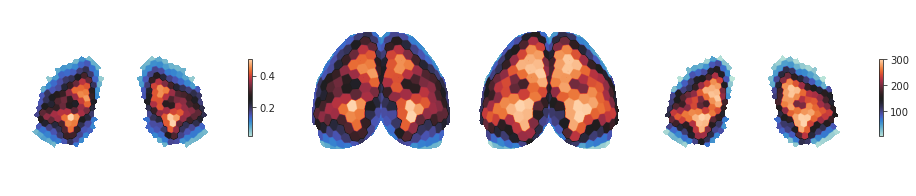

In [38]:
h, hr, proj_h, proj_hr = get_h(pi_arr, 'no_pi_avg')
show_h(proj_h, proj_hr)

<AxesSubplot:ylabel='Count'>

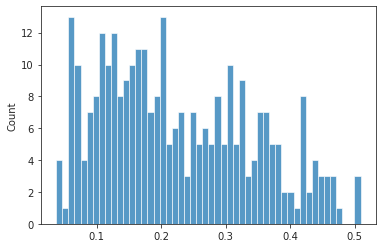

In [39]:
sns.histplot(h, bins=50)

### BOLD-Lite

#### Don't skip align

In [40]:
gr = Group(mode='bold-lite', centroids_from='runs', **props)
pi_arr, gam_arr, lam_arr = gr.fit_group(skip_align=False)

Warning, nan in global order

In [41]:
pi = bn.nanmean(pi_arr, -3)
pi_bold = bn.nanmean(pi.reshape(-1, *pi.shape[-2:]), 0)

disjoint = gr.get_disjoint_community(pi_bold, to_vec=True)
pi_bold = np.concatenate([pi_bold, np.expand_dims(disjoint, 0)])

pi_bold.shape

(7, 302)

In [42]:
proj_bold = gr.project_vec(pi_bold)

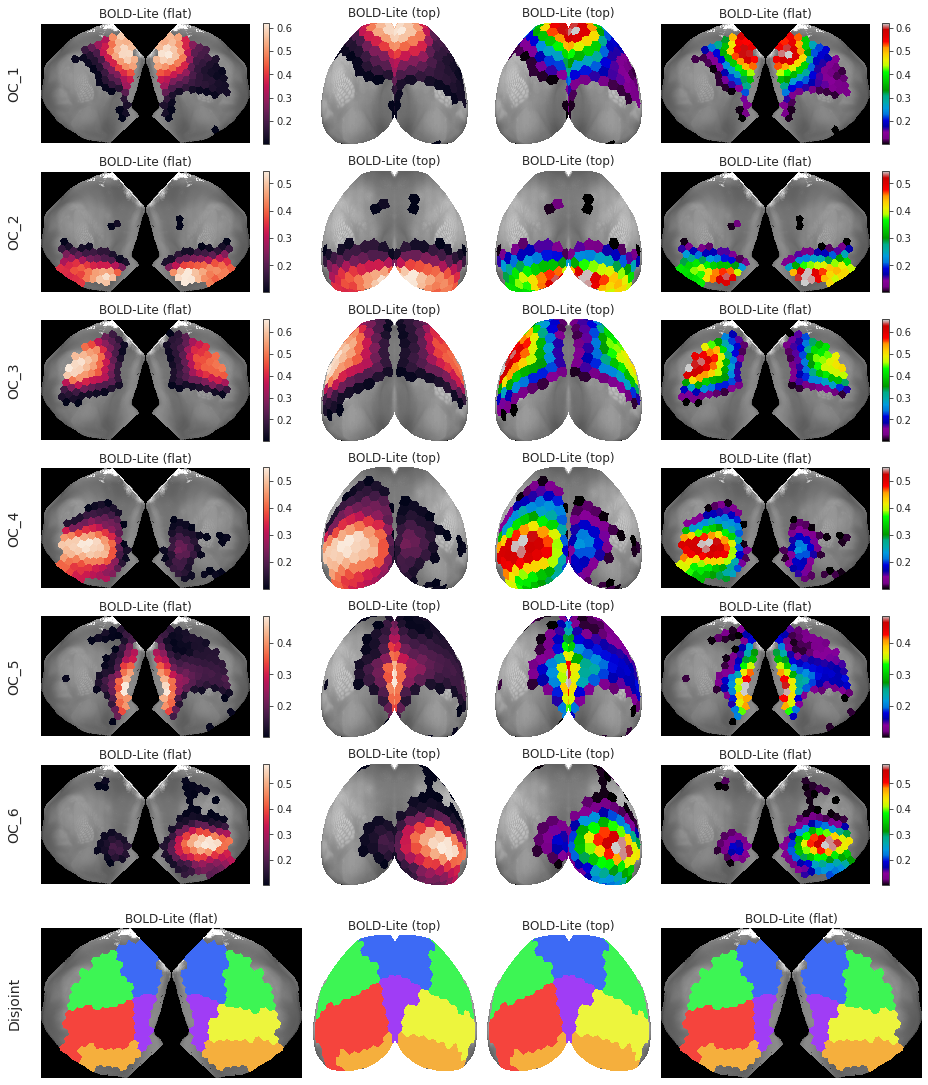

In [43]:
gr.show(proj_bold, labels=('BOLD-Lite',) * 2, cmaps=('rocket', 'nipy_spectral'))

In [44]:
sv = SVINET(**props, mode='bold-lite')
sv.pi_symmetry_score(pi_ca, 3)

{1: 0.98, 2: 0.981, 3: 0.987, 4: 0.988, 5: 0.972, 6: 0.975, -1: 0.981}

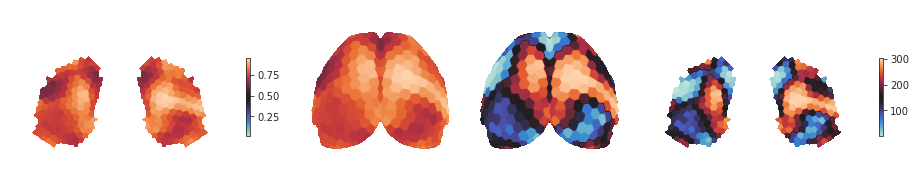

In [45]:
h, hr, proj_h, proj_hr = get_h(pi_arr, 'pi_animals')
show_h(proj_h, proj_hr)

<AxesSubplot:ylabel='Count'>

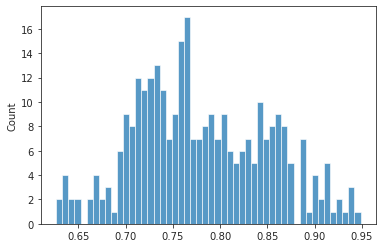

In [46]:
sns.histplot(h, bins=50)

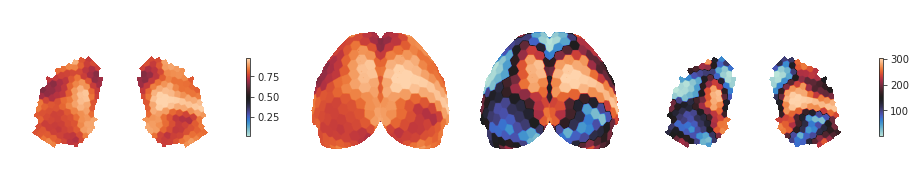

In [47]:
h, hr, proj_h, proj_hr = get_h(pi_arr, 'avg_pi_first')
show_h(proj_h, proj_hr)

<AxesSubplot:ylabel='Count'>

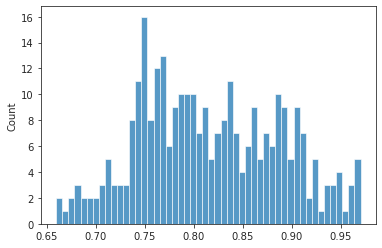

In [48]:
sns.histplot(h, bins=50)

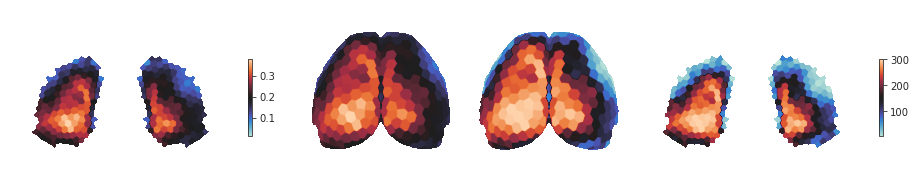

In [49]:
h, hr, proj_h, proj_hr = get_h(pi_arr, 'no_pi_avg')
show_h(proj_h, proj_hr)

<AxesSubplot:ylabel='Count'>

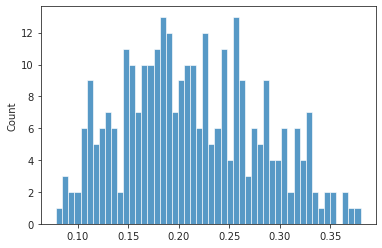

In [50]:
sns.histplot(h, bins=50)

#### Skip align

In [51]:
gr = Group(mode='bold-lite', centroids_from='runs', **props)
pi_arr, gam_arr, lam_arr = gr.fit_group(skip_align=True)

In [52]:
pi = bn.nanmean(pi_arr, -3)
pi_bold = bn.nanmean(pi.reshape(-1, *pi.shape[-2:]), 0)

disjoint = gr.get_disjoint_community(pi_bold, to_vec=True)
pi_bold = np.concatenate([pi_bold, np.expand_dims(disjoint, 0)])

pi_bold.shape

(7, 302)

In [53]:
proj_bold = gr.project_vec(pi_bold)

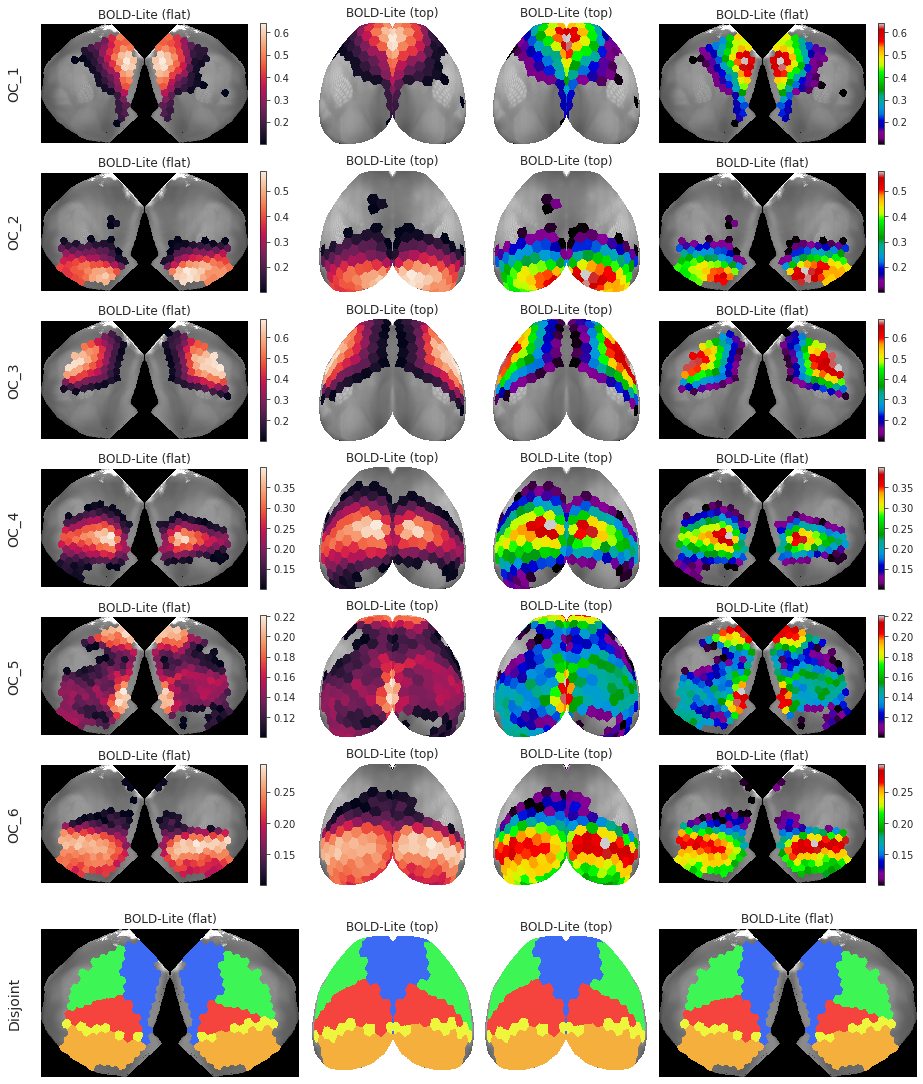

In [54]:
gr.show(proj_bold, labels=('BOLD-Lite',) * 2, cmaps=('rocket', 'nipy_spectral'))

In [55]:
sv = SVINET(**props, mode='bold-lite')
sv.pi_symmetry_score(pi_ca, 3)

{1: 0.98, 2: 0.981, 3: 0.987, 4: 0.988, 5: 0.972, 6: 0.975, -1: 0.981}

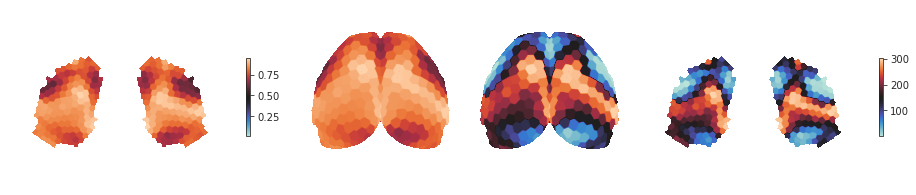

In [56]:
h, hr, proj_h, proj_hr = get_h(pi_arr, 'pi_animals')
show_h(proj_h, proj_hr)

<AxesSubplot:ylabel='Count'>

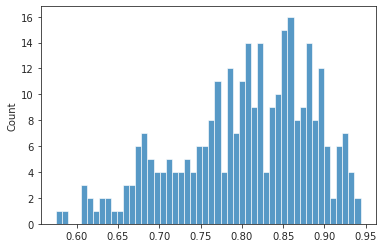

In [57]:
sns.histplot(h, bins=50)

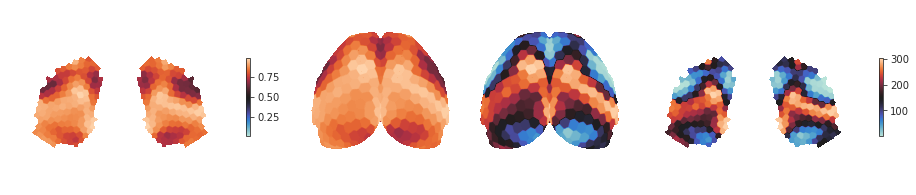

In [58]:
h, hr, proj_h, proj_hr = get_h(pi_arr, 'avg_pi_first')
show_h(proj_h, proj_hr)

<AxesSubplot:ylabel='Count'>

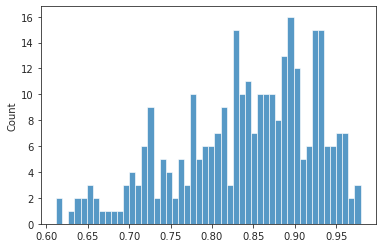

In [59]:
sns.histplot(h, bins=50)

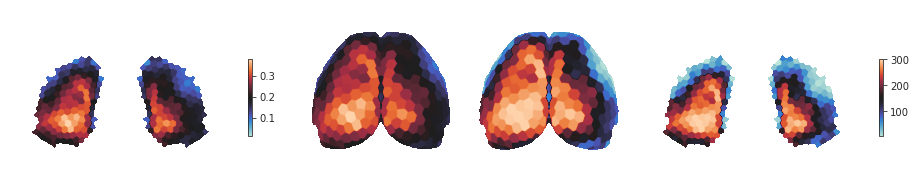

In [60]:
h, hr, proj_h, proj_hr = get_h(pi_arr, 'no_pi_avg')
show_h(proj_h, proj_hr)

<AxesSubplot:ylabel='Count'>

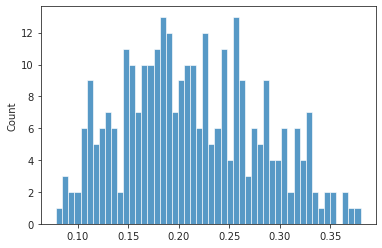

In [61]:
sns.histplot(h, bins=50)

## Old stuff

In [28]:
np.quantile(h, [0.25, 0.5, 0.75])

array([0.14407942, 0.23154938, 0.35732511])

<matplotlib.colorbar.Colorbar object at 0x7f119ee05370>

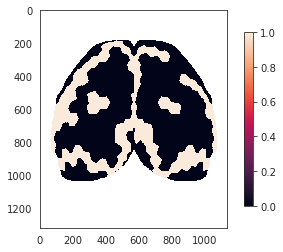

In [111]:
x2plt = proj_h['parcel2d-top'].squeeze()
x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
plt.imshow(np.logical_and(x2plt > np.quantile(h, 0.33), x2plt < np.quantile(h, 0.66)))
plt.colorbar(shrink=0.8)

In [131]:
h_vol = np.zeros(mice.parcel['cortex'].shape)

obj_idxs = pd.DataFrame(mice.parcel['cortex'].flat)
obj_idxs = obj_idxs.groupby([0]).indices

for ii, ids in obj_idxs.items():
    if ii == 0:
        continue
    hcl = mice.parcel.decode(int(ii))
    lr, cc, ll = hcl.flat
    node = gr.l2n.get(f"{lr}-{cc}-{ll}")
    if node is not None:
        h_vol.flat[ids] = h[node]
h_vol.shape

(132, 80, 114)

<matplotlib.colorbar.Colorbar object at 0x7f11b10a58b0>

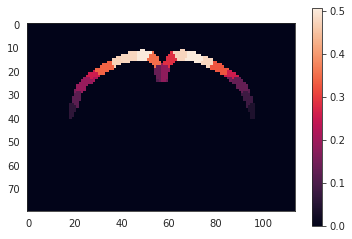

In [160]:
plt.imshow(h_vol[40])
plt.colorbar()

In [27]:
pi_anim = bn.nanmean(bn.nanmean(pi, 2), 1)
pi_anim.shape

(10, 5, 302)

In [28]:
pi_test = pi_anim[1]

In [29]:
disjoint = gr.get_disjoint_community(pi_test, to_vec=True)
pi_test = np.concatenate([pi_test, np.expand_dims(disjoint, 0)])

In [40]:
_proj = gr.project_vec(pi_test)

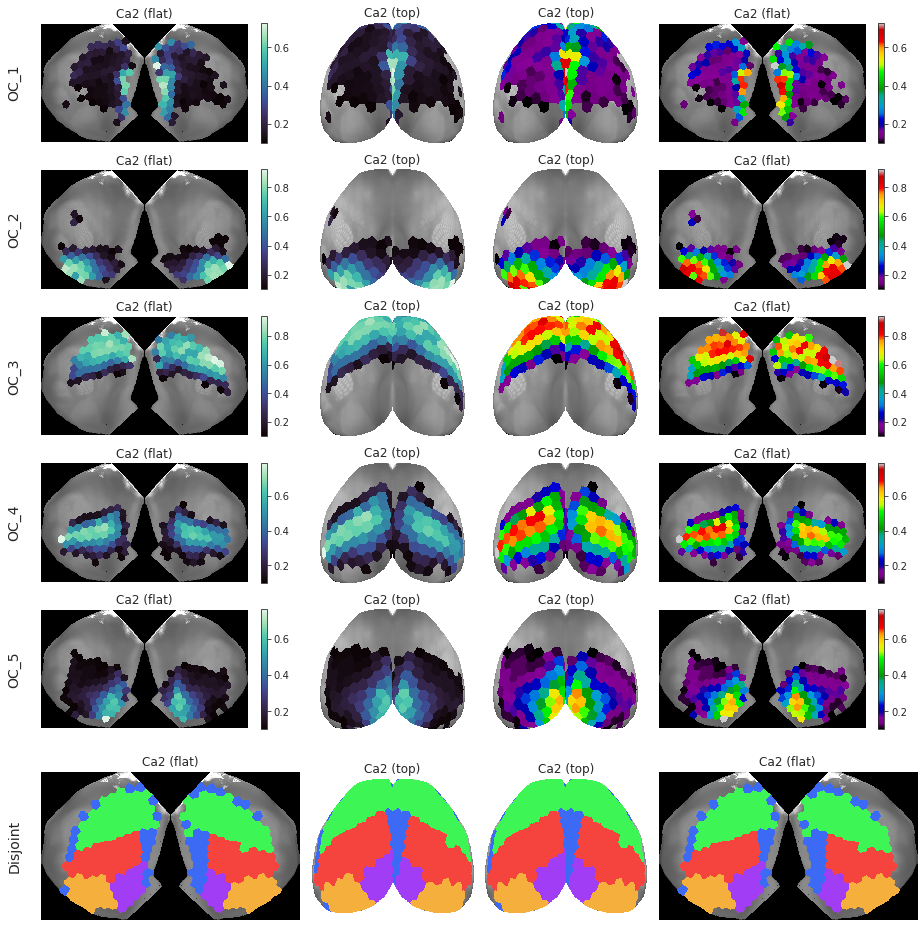

In [41]:
gr.show(_proj, labels=('Ca2',) * 2, cmaps=('mako', 'nipy_spectral'))